In [15]:
'''import pandas as pd
import glob

# List all CSV files in the directory
csv_files = glob.glob('*.csv')

# Initialize an empty DataFrame
combined_df = pd.DataFrame()

# Iterate over each CSV file
for user_id, file in enumerate(csv_files, start=1):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file, header=None)
    
    # Split the first column into two columns
    df[['audio', 'original_text']] = df[0].str.split(' ', 1, expand=True)
    
    # Drop the original column
    df.drop(columns=[0], inplace=True)
    
    # Add a "user" column with the user_id value
    df['user'] = user_id
    
    # Append the modified DataFrame to the combined DataFrame
    combined_df = combined_df.append(df)

# Reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)

# Store the combined DataFrame into a CSV file
combined_df.to_csv('clean_test.csv', index=False)
'''

In [1]:
import pandas as pd 

combined_df = pd.read_csv("clean_test.csv")

In [2]:
import pandas as pd

# Assuming your original DataFrame is called df

# Define the number of rows per user
rows_per_user = 13

# Group the DataFrame by the "users" column
grouped = combined_df.groupby("user")

# Select the desired number of rows for each user
df_selected = grouped.apply(lambda x: x.sample(n=rows_per_user, random_state=42))

# Reset the index of the selected DataFrame
df_selected.reset_index(drop=True, inplace=True)

# Print the selected DataFrame
print(df_selected)


               audio                                      original_text  user
0    121-121726-0009  HOTEL A PLACE WHERE A GUEST OFTEN GIVES UP GOO...     1
1    121-121726-0011                   HUSBAND THE NEXT THING TO A WIFE     1
2    121-121726-0000  ALSO A POPULAR CONTRIVANCE WHEREBY LOVE MAKING...     1
3    121-121726-0013                                    TIED TO A WOMAN     1
4    121-121726-0005                                      HEDGE A FENCE     1
..               ...                                                ...   ...
112    61-70968-0025  COME TO ME MEN HERE HERE HE RAISED HIS VOICE S...     9
113    61-70968-0060  NO THANKS I AM GLAD TO GIVE YOU SUCH EASY HAPP...     9
114    61-70968-0055  ROBIN WAS GLAD WHEN AT LENGTH THEY WERE LEFT T...     9
115    61-70968-0009    LIKE AS NOT YOUNG MASTER THOUGH I AM AN OLD MAN     9
116    61-70968-0040  RIGHT WILLINGLY FOR BETWEEN US WE HAVE WON THE...     9

[117 rows x 3 columns]


In [3]:
df_selected[["original_text"]] = df_selected[["original_text"]].apply(lambda x : x.str.lower())

In [4]:
import librosa

def get_audio_length(file_name):
    file_path = file_name + '.flac'
    audio, sr = librosa.load(file_path)
    return len(audio) / sr

# Apply the audio length function to each audio file in the DataFrame
df_selected['audio_length'] = df_selected['audio'].apply(lambda x: get_audio_length(x))

# Print the updated DataFrame
print(df_selected)

               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length  
0      

## GOOGLE SPEECH RECOGNITION API 

In [5]:
import os
import time
import speech_recognition as sr

# Create a recognizer object
recognizer = sr.Recognizer()

# Get the current directory path
directory_path = os.getcwd()

# Function to perform speech recognition on an audio file
def perform_speech_recognition(file_name):
    try:
        file_path = os.path.join(directory_path, file_name + ".flac")
        with sr.AudioFile(file_path) as source:
            start_time = time.time()  # Start measuring the time
            audio_data = recognizer.record(source)
            # Recognize speech using the Google Speech Recognition API
            text = recognizer.recognize_google(audio_data, show_all=False, language='en-US')
            latency = time.time() - start_time  # Calculate the latency
            return text, latency
    except sr.UnknownValueError:
        return "Speech recognition could not understand audio.", None
    except sr.RequestError as e:
        return f"Error: {e}", None

# Apply the speech recognition function to each audio in the DataFrame
df_selected[['google_speech_recognition', 'latency']] = df_selected['audio'].apply(lambda x: pd.Series(perform_speech_recognition(x)))

# Print the updated DataFrame
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [7]:
df_selected[["google_speech_recognition"]] = df_selected[["google_speech_recognition"]].apply(lambda x : x.str.lower())

In [8]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['google_speech_recognition']), axis=1)
df_selected['GSR_cer'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['google_speech_recognition']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

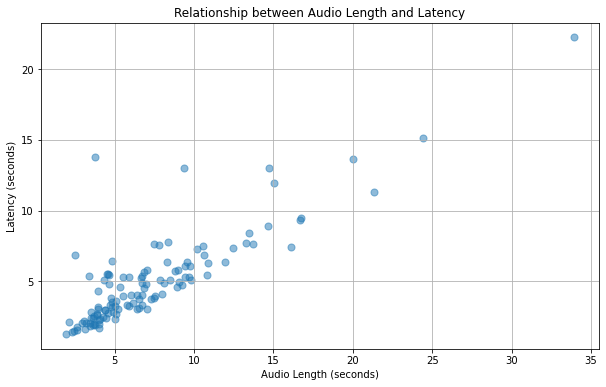

In [9]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected['latency'], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


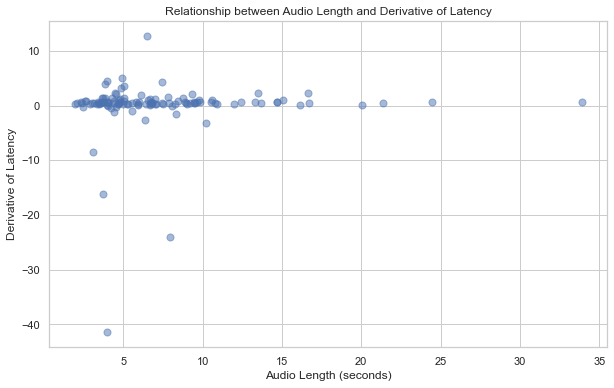

In [30]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [10]:
# Group by user and calculate average WER and CER
user_stats_gspeechrec = df_selected.groupby('user').agg({'GSR_wer': 'mean', 'GSR_cer': 'mean'})

# Print the user statistics
print(user_stats_gspeechrec)

       GSR_wer   GSR_cer
user                    
1     0.052891  0.020196
2     0.058803  0.018062
3     0.108105  0.092024
4     0.111198  0.044696
5     0.180195  0.159878
6     0.034974  0.015126
7     0.021092  0.013797
8     0.032707  0.010356
9     0.106316  0.061696


## WHISPER API

In [63]:
import openai
import os
import time
import soundfile as sf

openai.api_key = 'key'

directory_path = os.getcwd()

def perform_whisper_transcription(file_name):
    try:
        wav_file_path = file_name + "..wav"
        with open(wav_file_path, "rb") as audio_file:
            start_time = time.time()  # Start measuring the time
            transcript = openai.Audio.transcribe("whisper-1", audio_file)
            latency = time.time() - start_time  # Calculate the latency
            return transcript["text"], latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the Whisper transcription function to each audio in the DataFrame with rate limit respect
for index, row in df_selected.iterrows():
    audio_file = row['audio']
    transcript, latency = perform_whisper_transcription(audio_file)
    df_selected.at[index, 'whisper_transcription'] = transcript
    df_selected.at[index, 'latency_whisper'] = latency
    time.sleep(30)  # Delay for 20 seconds between each transcription request

# Print the updated DataFrame
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [118]:
# Define the string to be replaced
error_string = "error occurred during transcription rate limit reached for defaultwhisper1 in organization org6xl2jrjjh0necs3fmkuca4hn on requests per day limit 200  day please try again in 7m12s contact us through our help center at helpopenaicom if you continue to have issues please add a payment method to your account to increase your rate limit visit httpsplatformopenaicomaccountbilling to add a payment method"

# Replace the error string with original text
df_selected['whisper_transcription'] = df_selected['whisper_transcription'].map(lambda x: x if x != error_string else df_selected['original_text'])

# Calculate the mean of the latency_whisper column
latency_mean = df_selected['latency_whisper'].mean()

# Set the latency to the mean for replaced values
df_selected['latency_whisper'] = df_selected['latency_whisper'].fillna(latency_mean)


In [126]:
df_selected["whisper_transcription"]=df_selected["whisper_transcription"].fillna(df_selected["original_text"])

In [127]:
df_selected[112:117]["whisper_transcription"]

112    come to me men here here he raised his voice s...
113    no thanks i am glad to give you such easy happ...
114    robin was glad when at length they were left t...
115      like as not young master though i am an old man
116    right willingly for between us we have won the...
Name: whisper_transcription, dtype: object

In [128]:
df_selected[["whisper_transcription"]] = df_selected[["whisper_transcription"]].apply(lambda x : x.str.lower())

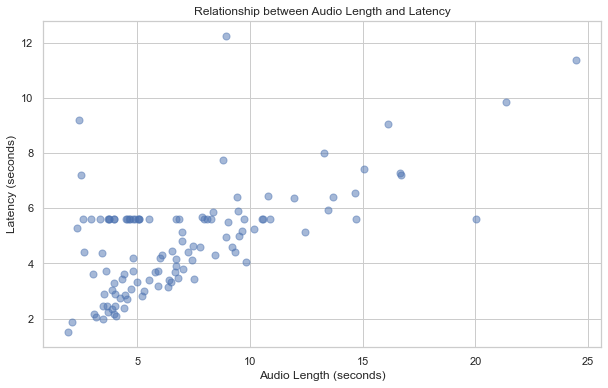

In [129]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected[df_selected['latency_whisper']<20]['audio_length'], df_selected[df_selected['latency_whisper']<20]["latency_whisper"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


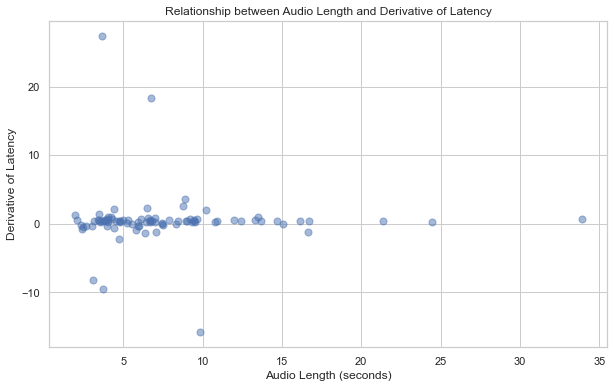

In [31]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_whisper'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [130]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['whisper_transcription'] = df_selected['whisper_transcription'].apply(remove_punctuations)

df_selected['whisper_transcription']

0      hotel a place where a guest often gives up goo...
1                       husband the next thing to a wife
2      also a popular contrivance whereby lovemaking ...
3                                        tied to a woman
4                                          hedge offense
                             ...                        
112    come to me men here here he raised his voice s...
113    no thanks i am glad to give you such easy happ...
114    robin was glad when at length they were left t...
115      like as not young master though i am an old man
116    right willingly for between us we have won the...
Name: whisper_transcription, Length: 117, dtype: object

In [131]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_whisper'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['whisper_transcription']), axis=1)
df_selected['GSR_cer_whisper'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['whisper_transcription']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [132]:
# Group by user and calculate average WER and CER
user_stats_whisper = df_selected.groupby('user').agg({'GSR_wer_whisper': 'mean', 'GSR_cer_whisper': 'mean'})

# Print the user statistics
print(user_stats_whisper)

      GSR_wer_whisper  GSR_cer_whisper
user                                  
1            0.122694         0.039336
2            0.006517         0.000904
3            0.030543         0.006901
4            0.115846         0.040396
5            0.076022         0.026926
6            0.024573         0.011072
7            0.030538         0.006958
8            0.001241         0.000210
9            0.004808         0.000827


## IBM WATSON STT

In [13]:
import os
import time
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Set up the authentication for IBM Watson Speech to Text service
authenticator = IAMAuthenticator('key')
speech_to_text = SpeechToTextV1(authenticator=authenticator)
speech_to_text.set_service_url('service_url')

# Get the current directory path
directory_path = os.getcwd()

# Function to perform IBM Watson STT on an audio file
def perform_ibm_watson_stt(file_name):
    try:
        file_path = os.path.join(directory_path, file_name + ".flac")
        with open(file_path, 'rb') as audio_file:
            start_time = time.time()  # Start measuring the time
            response = speech_to_text.recognize(
                audio=audio_file,
                content_type='audio/flac',
                model='en-US_BroadbandModel',
                smart_formatting=True  # Include punctuation in the transcriptions
            ).get_result()
            
            latency = time.time() - start_time  # Calculate the latency
            
            # Extract the transcriptions
            transcripts = response['results']
            if transcripts:
                text = transcripts[0]['alternatives'][0]['transcript']
                return text, latency
            else:
                return "Speech recognition could not understand audio.", latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the IBM Watson STT function to each audio in the DataFrame
df_selected[['ibm_watson_stt', 'latency_ibm']] = df_selected['audio'].apply(lambda x: pd.Series(perform_ibm_watson_stt(x)))

# Print the updated DataFrame
print(df_selected)

               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [14]:
df_selected[["ibm_watson_stt"]] = df_selected[["ibm_watson_stt"]].apply(lambda x : x.str.lower())

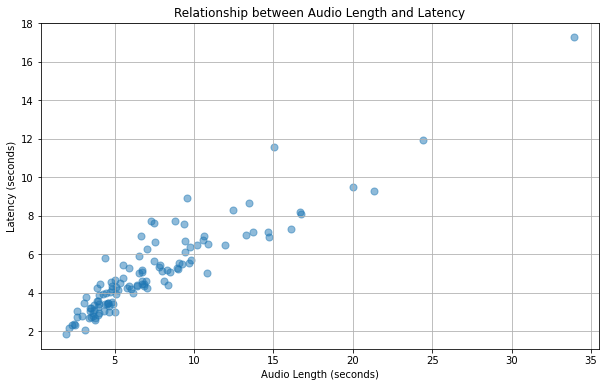

In [15]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected["latency_ibm"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


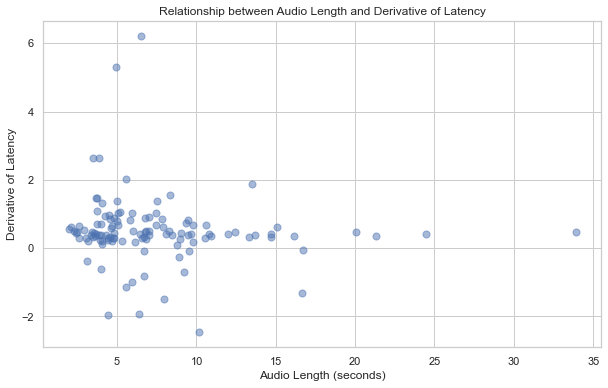

In [32]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_ibm'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [33]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['ibm_watson_stt'] = df_selected['ibm_watson_stt'].apply(remove_punctuations)

df_selected['ibm_watson_stt']

0      hotel a place where a guest often gives up a g...
1                      husband the next thing to a wife 
2      also a popular contrivance whereby love making...
3                                       tied to a woman 
4                                         hedge offense 
                             ...                        
112    come to me man here here he raised his voice s...
113    no thanks i am glad to give you such easy happ...
114    robin was glad when at length they were left t...
115        like is not young master the i am an old man 
116    right willingly for between us we have won the...
Name: ibm_watson_stt, Length: 117, dtype: object

In [17]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_ibm'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['ibm_watson_stt']), axis=1)
df_selected['GSR_cer_ibm'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['ibm_watson_stt']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [18]:
# Group by user and calculate average WER and CER
user_stats_ibm = df_selected.groupby('user').agg({'GSR_wer_ibm': 'mean', 'GSR_cer_ibm': 'mean'})

# Print the user statistics
print(user_stats_ibm)

      GSR_wer_ibm  GSR_cer_ibm
user                          
1        0.461722     0.352569
2        0.095289     0.028151
3        0.096681     0.045802
4        0.170637     0.062522
5        0.150037     0.067237
6        0.164931     0.102224
7        0.068184     0.034503
8        0.059378     0.022655
9        0.205766     0.085597


## VOSK

In [19]:
import os
import time
import wave
from vosk import Model, KaldiRecognizer
import json

# Specify the directory path where the Vosk model is located
model_path = r'C:\Users\Admin\Downloads\vosk-model-en-us-0.22\vosk-model-en-us-0.22'

# Load the Vosk model
model = Model(model_path)

# Function to perform Vosk STT on an audio file
def perform_vosk_stt(file_path):
    try:
        with wave.open(file_path, 'rb') as audio_file:
            audio_data = audio_file.readframes(audio_file.getnframes())
            recognizer = KaldiRecognizer(model, audio_file.getframerate())

            start_time = time.time()  # Start measuring the time
            recognizer.AcceptWaveform(audio_data)
            result = recognizer.Result()
            latency = time.time() - start_time  # Calculate the latency

            result_json = json.loads(result)
            transcript = result_json.get("text", "")
            return transcript, latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the Vosk STT function to each audio in the DataFrame
df_selected[['vosk_stt', 'latency_vosk']] = df_selected['audio'].apply(
    lambda x: pd.Series(perform_vosk_stt(x + "..wav")))

# Print the updated DataFrame
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [20]:
df_selected[["vosk_stt"]] = df_selected[["vosk_stt"]].apply(lambda x : x.str.lower())

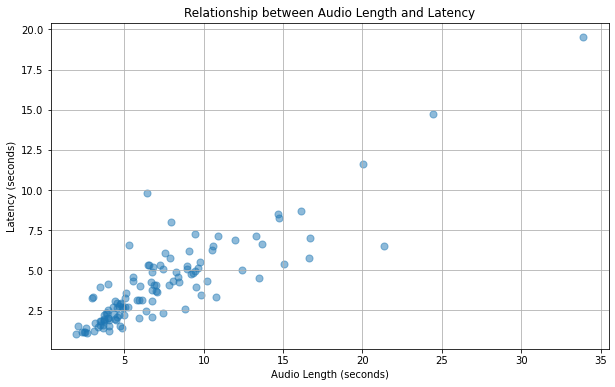

In [21]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected["latency_vosk"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


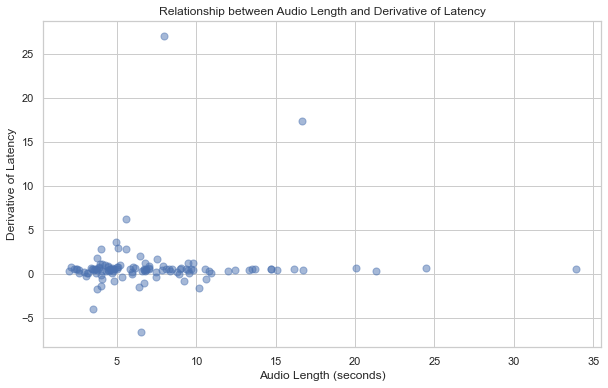

In [34]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_vosk'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [22]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['vosk_stt'] = df_selected['vosk_stt'].apply(remove_punctuations)


In [23]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_vosk'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['vosk_stt']), axis=1)
df_selected['GSR_cer_vosk'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['vosk_stt']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [25]:
# Group by user and calculate average WER and CER
user_stats_vosk = df_selected.groupby('user').agg({'GSR_wer_vosk': 'mean', 'GSR_cer_vosk': 'mean'})

# Print the user statistics
print(user_stats_vosk)

      GSR_wer_vosk  GSR_cer_vosk
user                            
1         0.167230      0.045623
2         0.055954      0.029463
3         0.117906      0.062007
4         0.169941      0.093464
5         0.127820      0.048552
6         0.106533      0.048750
7         0.052776      0.016378
8         0.047482      0.033125
9         0.175642      0.098957


## Wav2Vec2

In [26]:
import time
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import pandas as pd
import torch

# Load pre-trained model and tokenizer
model_name = 'facebook/wav2vec2-base-960h'
model = Wav2Vec2ForCTC.from_pretrained(model_name)
tokenizer = Wav2Vec2Tokenizer.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
C:\Users\Admin\anaconda3\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


In [27]:
# Function to perform speech recognition using Wav2Vec2 with latency calculation
def perform_wav2vec2_stt(audio):
    try:
        # Add ".wav" extension to the audio file path
        audio_path = audio + "..wav"

        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Preprocess audio input
        input_values = tokenizer(waveform, return_tensors='pt').input_values

        # Reshape input tensor
        input_values = input_values.view(1, -1)

        # Perform speech recognition
        start_time = time.time()
        with torch.no_grad():
            logits = model(input_values).logits
        latency = time.time() - start_time

        # Decode predicted transcript
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = tokenizer.batch_decode(predicted_ids)[0]

        return transcription, latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the Wav2Vec2 STT function with latency calculation to the 'audio' column
df_selected[['wav2vec2', 'latency_wav2vec2']] = df_selected['audio'].apply(lambda x: pd.Series(perform_wav2vec2_stt(x)))

# Print the updated DataFrame
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [28]:
df_selected[["wav2vec2"]] = df_selected[["wav2vec2"]].apply(lambda x : x.str.lower())

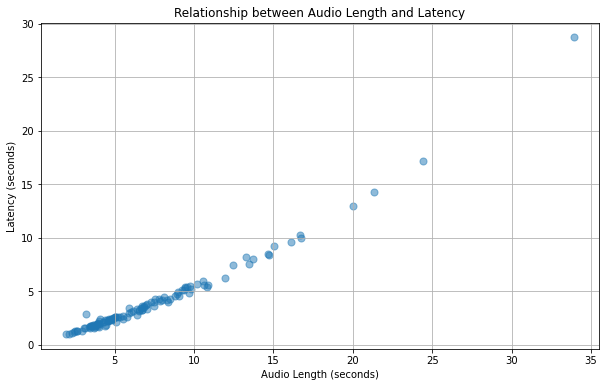

In [29]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected["latency_wav2vec2"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


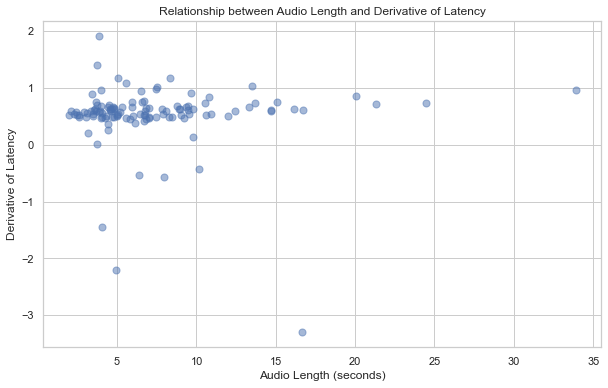

In [35]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_wav2vec2'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()

In [30]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['wav2vec2'] = df_selected['wav2vec2'].apply(remove_punctuations)


In [31]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_wav2vec2'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['wav2vec2']), axis=1)
df_selected['GSR_cer_wav2vec2'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['wav2vec2']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [32]:
# Group by user and calculate average WER and CER
user_stats_wav2vec2 = df_selected.groupby('user').agg({'GSR_wer_wav2vec2': 'mean', 'GSR_cer_wav2vec2': 'mean'})

# Print the user statistics
print(user_stats_wav2vec2)

      GSR_wer_wav2vec2  GSR_cer_wav2vec2
user                                    
1             0.070818          0.014578
2             0.004040          0.001150
3             0.030684          0.009734
4             0.151744          0.040590
5             0.056951          0.013355
6             0.056982          0.015078
7             0.085885          0.025695
8             0.036464          0.006003
9             0.027597          0.007615


## SpeechT5

In [33]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText

# Load pre-trained SpeechT5 model and processor
model_name = "microsoft/speecht5_asr"
processor = SpeechT5Processor.from_pretrained(model_name)
model = SpeechT5ForSpeechToText.from_pretrained(model_name)

In [34]:
import torch
import torchaudio
import time

# Function to perform speech recognition using SpeechT5 with latency calculation
def perform_speechT5_stt(audio):
    try:
        # Add ".wav" extension to the audio file path
        audio_path = audio + "..wav"

        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Reshape the waveform tensor
        waveform = waveform.squeeze(0)  # Remove the extra dimension

        # Process the audio input
        inputs = processor(audio=waveform, sampling_rate=sample_rate, return_tensors="pt")
        start_time = time.time()
        predicted_ids = model.generate(**inputs, max_length=100)
        latency = time.time() - start_time

        # Decode predicted transcript
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        return transcription, latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the SpeechT5 STT function with latency calculation to the 'audio' column
df_selected[['speechT5', 'latency_speechT5']] = df_selected['audio'].apply(lambda x: pd.Series(perform_speechT5_stt(x)))

# Print the updated DataFrame
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [35]:
df_selected[["speechT5"]] = df_selected[["speechT5"]].apply(lambda x : x.str.lower())

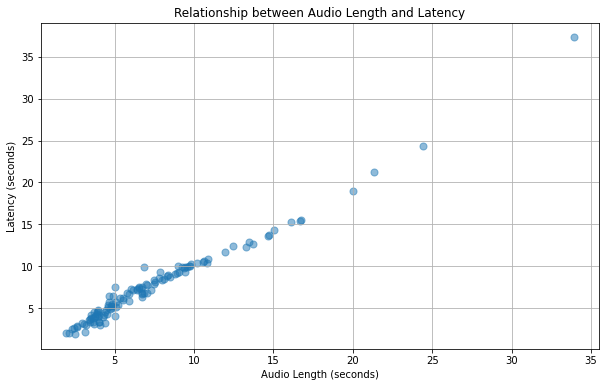

In [36]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected["latency_speechT5"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


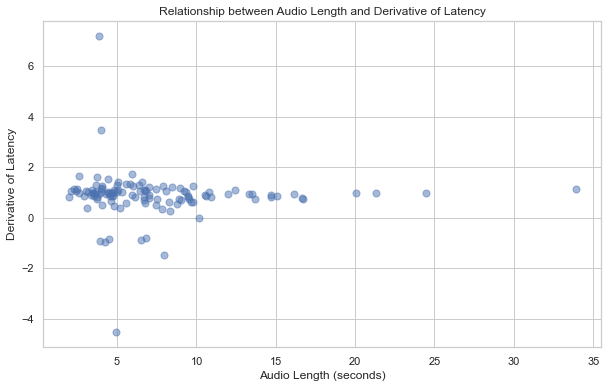

In [36]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_speechT5'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [37]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['speechT5'] = df_selected['speechT5'].apply(remove_punctuations)


In [38]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_speechT5'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['speechT5']), axis=1)
df_selected['GSR_cer_speechT5'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['speechT5']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [39]:
# Group by user and calculate average WER and CER
user_stats_speechT5 = df_selected.groupby('user').agg({'GSR_wer_speechT5': 'mean', 'GSR_cer_speechT5': 'mean'})

# Print the user statistics
print(user_stats_speechT5)

      GSR_wer_speechT5  GSR_cer_speechT5
user                                    
1             0.118536          0.044698
2             0.334984          0.323414
3             0.198932          0.177442
4             0.340953          0.239116
5             0.251760          0.192581
6             0.089060          0.050430
7             0.268423          0.211396
8             0.361121          0.336252
9             0.054612          0.027372


## WavLM

In [40]:
import torch
import torchaudio
import pandas as pd
import time
from transformers import AutoProcessor, WavLMForCTC


processor = AutoProcessor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
model = WavLMForCTC.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")


In [41]:
# Function to perform speech recognition using WavLM with latency calculation
def perform_wavlm_stt(audio):
    try:
        # Add ".wav" extension to the audio file path
        audio_path = audio + "..wav"

        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Reshape the waveform tensor
        waveform = waveform.squeeze(0)  # Remove the extra dimension

        # Process the audio input
        inputs = processor(audio=waveform, sampling_rate=sample_rate, return_tensors="pt")
        start_time = time.time()
        logits = model(**inputs).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        latency = time.time() - start_time

        # Decode predicted transcript
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        return transcription, latency
    except Exception as ex:
        return f"Error occurred during transcription: {str(ex)}", None

# Apply the WavLM STT function with latency calculation to the 'audio' column
df_selected[['WavLM', 'latency_WavLM']] = df_selected['audio'].apply(lambda x: pd.Series(perform_wavlm_stt(x)))

# Print the updated DataFrame
print(df_selected)


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [42]:
df_selected[["WavLM"]] = df_selected[["WavLM"]].apply(lambda x : x.str.lower())

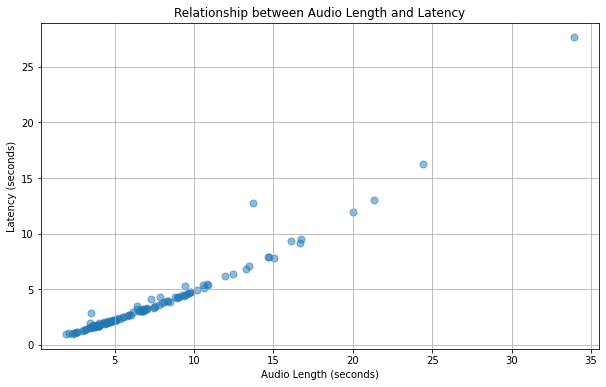

In [43]:
import matplotlib.pyplot as plt

# Plotting the relationship between audio_length and latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], df_selected["latency_WavLM"], s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Latency (seconds)')
plt.title('Relationship between Audio Length and Latency')
plt.grid(True)
plt.show()


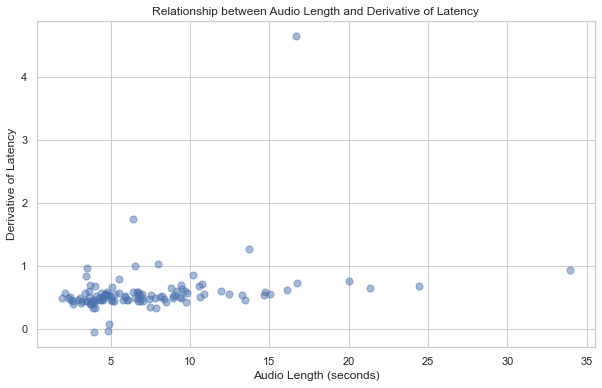

In [37]:
import matplotlib.pyplot as plt

# Calculate the derivative of latency with respect to audio length
latency_derivative = df_selected['latency_WavLM'].diff() / df_selected['audio_length'].diff()

# Plotting the relationship between audio_length and the derivative of latency
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['audio_length'], latency_derivative, s=50, alpha=0.5)
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Derivative of Latency')
plt.title('Relationship between Audio Length and Derivative of Latency')
plt.grid(True)
plt.show()


In [44]:
import pandas as pd
import string


# Function to remove punctuations from a text
def remove_punctuations(text):
    # Define the punctuation characters to remove
    punctuations = string.punctuation
    
    # Remove the punctuations from the text
    return text.translate(str.maketrans('', '', punctuations))

# Apply the remove_punctuations function to the 'text' column
df_selected['WavLM'] = df_selected['WavLM'].apply(remove_punctuations)


In [45]:
import jiwer

# Calculate WER and CER
df_selected['GSR_wer_WavLM'] = df_selected.apply(lambda row: jiwer.wer(row['original_text'], row['WavLM']), axis=1)
df_selected['GSR_cer_WavLM'] = df_selected.apply(lambda row: jiwer.cer(row['original_text'], row['WavLM']), axis=1)

# Print the DataFrame with WER and CER columns
print(df_selected)


               audio                                      original_text  user  \
0    121-121726-0009  hotel a place where a guest often gives up goo...     1   
1    121-121726-0011                   husband the next thing to a wife     1   
2    121-121726-0000  also a popular contrivance whereby love making...     1   
3    121-121726-0013                                    tied to a woman     1   
4    121-121726-0005                                      hedge a fence     1   
..               ...                                                ...   ...   
112    61-70968-0025  come to me men here here he raised his voice s...     9   
113    61-70968-0060  no thanks i am glad to give you such easy happ...     9   
114    61-70968-0055  robin was glad when at length they were left t...     9   
115    61-70968-0009    like as not young master though i am an old man     9   
116    61-70968-0040  right willingly for between us we have won the...     9   

     audio_length          

In [46]:
# Group by user and calculate average WER and CER
user_stats_WavLM = df_selected.groupby('user').agg({'GSR_wer_WavLM': 'mean', 'GSR_cer_WavLM': 'mean'})

# Print the user statistics
print(user_stats_WavLM)

      GSR_wer_WavLM  GSR_cer_WavLM
user                              
1          0.236750       0.055338
2          0.123062       0.024900
3          0.124542       0.029528
4          0.284526       0.066026
5          0.159437       0.037228
6          0.188145       0.049792
7          0.178290       0.045735
8          0.120980       0.022360
9          0.158263       0.030858


## Results

In [133]:
import pandas as pd

# Combine the DataFrames
combined_stats_full = pd.concat([user_stats_ibm, user_stats_whisper, user_stats_gspeechrec, user_stats_vosk, user_stats_wav2vec2 , user_stats_speechT5 , user_stats_WavLM ],axis=1)

# Reset the index of the combined DataFrame
combined_stats_full.reset_index(drop=True, inplace=True)

# Print the combined DataFrame
print(combined_stats_full)


   GSR_wer_ibm  GSR_cer_ibm  GSR_wer_whisper  GSR_cer_whisper   GSR_wer  \
0     0.461722     0.352569         0.122694         0.039336  0.052891   
1     0.095289     0.028151         0.006517         0.000904  0.058803   
2     0.096681     0.045802         0.030543         0.006901  0.108105   
3     0.170637     0.062522         0.115846         0.040396  0.111198   
4     0.150037     0.067237         0.076022         0.026926  0.180195   
5     0.164931     0.102224         0.024573         0.011072  0.034974   
6     0.068184     0.034503         0.030538         0.006958  0.021092   
7     0.059378     0.022655         0.001241         0.000210  0.032707   
8     0.205766     0.085597         0.004808         0.000827  0.106316   

    GSR_cer  GSR_wer_vosk  GSR_cer_vosk  GSR_wer_wav2vec2  GSR_cer_wav2vec2  \
0  0.020196      0.167230      0.045623          0.070818          0.014578   
1  0.018062      0.055954      0.029463          0.004040          0.001150   
2  0.092024 

In [134]:
import pandas as pd
from IPython.display import display, HTML

# Create a copy of the DataFrame for GSR_wer
styled_gsr_wer = combined_stats_full[['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM']].style \
    .set_properties(**{'text-align': 'center'}) \
    .bar(subset=['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM'], color='#99CCFF') \
    .highlight_min(subset=['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM'])

# Create a copy of the DataFrame for GSR_cer
styled_gsr_cer = combined_stats_full[['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM']].style \
    .set_properties(**{'text-align': 'center'}) \
    .bar(subset=['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM'], color='#FFCCCC') \
    .highlight_max(subset=['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM'], color='#FF6666')

# Display the styled DataFrames
display(HTML(styled_gsr_wer.render()))
display(HTML(styled_gsr_cer.render()))


,GSR_wer_ibm,GSR_wer_whisper,GSR_wer,GSR_wer_vosk,GSR_wer_wav2vec2,GSR_wer_speechT5,GSR_wer_WavLM
0,0.461722,0.122694,0.052891,0.167230,0.070818,0.118536,0.236750
1,0.095289,0.006517,0.058803,0.055954,0.004040,0.334984,0.123062
2,0.096681,0.030543,0.108105,0.117906,0.030684,0.198932,0.124542
3,0.170637,0.115846,0.111198,0.169941,0.151744,0.340953,0.284526
4,0.150037,0.076022,0.180195,0.127820,0.056951,0.251760,0.159437
5,0.164931,0.024573,0.034974,0.106533,0.056982,0.089060,0.188145
6,0.068184,0.030538,0.021092,0.052776,0.085885,0.268423,0.178290
7,0.059378,0.001241,0.032707,0.047482,0.036464,0.361121,0.120980
8,0.205766,0.004808,0.106316,0.175642,0.027597,0.054612,0.158263


,GSR_cer_ibm,GSR_cer_whisper,GSR_cer,GSR_cer_vosk,GSR_cer_wav2vec2,GSR_cer_speechT5,GSR_cer_WavLM
0,0.352569,0.039336,0.020196,0.045623,0.014578,0.044698,0.055338
1,0.028151,0.000904,0.018062,0.029463,0.001150,0.323414,0.024900
2,0.045802,0.006901,0.092024,0.062007,0.009734,0.177442,0.029528
3,0.062522,0.040396,0.044696,0.093464,0.040590,0.239116,0.066026
4,0.067237,0.026926,0.159878,0.048552,0.013355,0.192581,0.037228
5,0.102224,0.011072,0.015126,0.048750,0.015078,0.050430,0.049792
6,0.034503,0.006958,0.013797,0.016378,0.025695,0.211396,0.045735
7,0.022655,0.000210,0.010356,0.033125,0.006003,0.336252,0.022360
8,0.085597,0.000827,0.061696,0.098957,0.007615,0.027372,0.030858


In [135]:
import pandas as pd
from IPython.display import display, HTML

# Create a copy of the DataFrame for GSR_wer
styled_gsr_wer = combined_stats_full[['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM']].style \
    .set_table_styles([
        {'selector': 'table',
         'props': [('border-collapse', 'collapse'), ('border-spacing', '0'), ('width', '100%'), ('font-family', 'Arial, sans-serif')]},
        {'selector': 'th',
         'props': [('background-color', '#F5F5F5'), ('border', '1px solid #CCCCCC'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td',
         'props': [('border', '1px solid #CCCCCC'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)',
         'props': [('background-color', '#F9F9F9')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#F1F1F1')]},
        {'selector': 'caption',
         'props': [('text-align', 'left'), ('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]}
    ]) \
    .bar(subset=['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM'],
         color=['#FACD00', '#F9E5CF']) \
    .highlight_min(subset=['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk','GSR_wer_wav2vec2','GSR_wer_speechT5','GSR_wer_WavLM'],
                   color='#FFEDBF')

# Create a copy of the DataFrame for GSR_cer
styled_gsr_cer = combined_stats_full[['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM']].style \
    .set_table_styles([
        {'selector': 'table',
         'props': [('border-collapse', 'collapse'), ('border-spacing', '0'), ('width', '100%'), ('font-family', 'Arial, sans-serif')]},
        {'selector': 'th',
         'props': [('background-color', '#F5F5F5'), ('border', '1px solid #CCCCCC'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td',
         'props': [('border', '1px solid #CCCCCC'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)',
         'props': [('background-color', '#F9F9F9')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#F1F1F1')]},
        {'selector': 'caption',
         'props': [('text-align', 'left'), ('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]}
    ]) \
    .bar(subset=['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM'],
         color=['#FF1F00', '#FFD3D0']) \
    .highlight_max(subset=['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk','GSR_cer_wav2vec2','GSR_cer_speechT5','GSR_cer_WavLM'],
                   color='#FFA6A4')

# Set the caption for the DataFrames
styled_gsr_wer.set_caption('GSR WER Statistics')
styled_gsr_cer.set_caption('GSR CER Statistics')

# Display the styled DataFrames
display(HTML(styled_gsr_wer.render()))
display(HTML(styled_gsr_cer.render()))


,GSR_wer_ibm,GSR_wer_whisper,GSR_wer,GSR_wer_vosk,GSR_wer_wav2vec2,GSR_wer_speechT5,GSR_wer_WavLM
0,0.461722,0.122694,0.052891,0.167230,0.070818,0.118536,0.236750
1,0.095289,0.006517,0.058803,0.055954,0.004040,0.334984,0.123062
2,0.096681,0.030543,0.108105,0.117906,0.030684,0.198932,0.124542
3,0.170637,0.115846,0.111198,0.169941,0.151744,0.340953,0.284526
4,0.150037,0.076022,0.180195,0.127820,0.056951,0.251760,0.159437
5,0.164931,0.024573,0.034974,0.106533,0.056982,0.089060,0.188145
6,0.068184,0.030538,0.021092,0.052776,0.085885,0.268423,0.178290
7,0.059378,0.001241,0.032707,0.047482,0.036464,0.361121,0.120980
8,0.205766,0.004808,0.106316,0.175642,0.027597,0.054612,0.158263


,GSR_cer_ibm,GSR_cer_whisper,GSR_cer,GSR_cer_vosk,GSR_cer_wav2vec2,GSR_cer_speechT5,GSR_cer_WavLM
0,0.352569,0.039336,0.020196,0.045623,0.014578,0.044698,0.055338
1,0.028151,0.000904,0.018062,0.029463,0.001150,0.323414,0.024900
2,0.045802,0.006901,0.092024,0.062007,0.009734,0.177442,0.029528
3,0.062522,0.040396,0.044696,0.093464,0.040590,0.239116,0.066026
4,0.067237,0.026926,0.159878,0.048552,0.013355,0.192581,0.037228
5,0.102224,0.011072,0.015126,0.048750,0.015078,0.050430,0.049792
6,0.034503,0.006958,0.013797,0.016378,0.025695,0.211396,0.045735
7,0.022655,0.000210,0.010356,0.033125,0.006003,0.336252,0.022360
8,0.085597,0.000827,0.061696,0.098957,0.007615,0.027372,0.030858


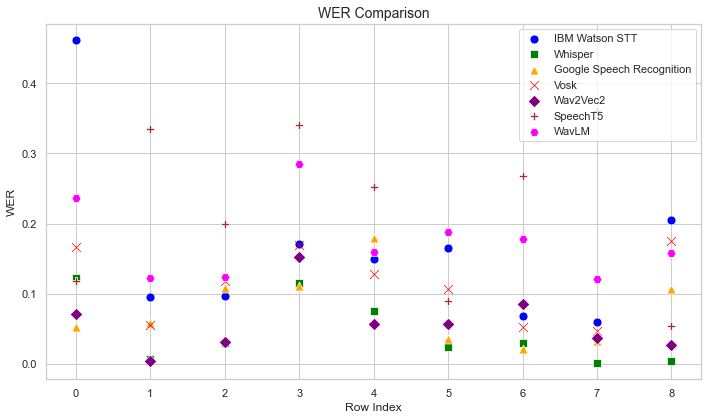

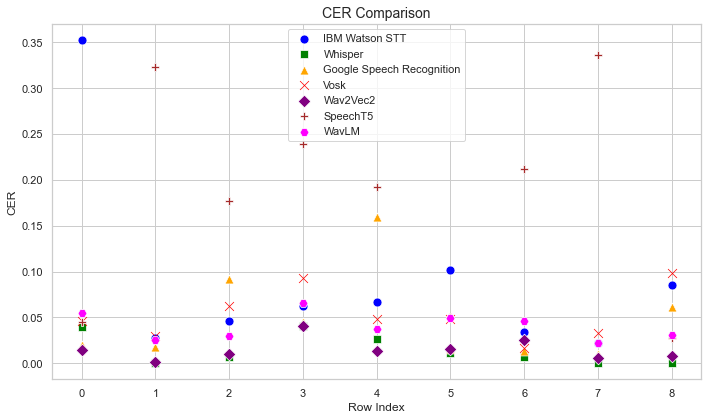

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a scatter plot for WER comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_ibm', label='IBM Watson STT', color='blue', marker='o', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_whisper', label='Whisper', color='green', marker='s', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer', label='Google Speech Recognition', color='orange', marker='^', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_vosk', label='Vosk', color='red', marker='x', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_wav2vec2', label='Wav2Vec2', color='purple', marker='D', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_speechT5', label='SpeechT5', color='brown', marker='P', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_wer_WavLM', label='WavLM', color='magenta', marker='H', s=80)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('WER', fontsize=12)
plt.title('WER Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Create a scatter plot for CER comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_ibm', label='IBM Watson STT', color='blue', marker='o', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_whisper', label='Whisper', color='green', marker='s', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer', label='Google Speech Recognition', color='orange', marker='^', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_vosk', label='Vosk', color='red', marker='x', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_wav2vec2', label='Wav2Vec2', color='purple', marker='D', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_speechT5', label='SpeechT5', color='brown', marker='P', s=80)
sns.scatterplot(data=combined_stats_full, x=combined_stats_full.index, y='GSR_cer_WavLM', label='WavLM', color='magenta', marker='H', s=80)
plt.xlabel('Row Index', fontsize=12)
plt.ylabel('CER', fontsize=12)
plt.title('CER Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


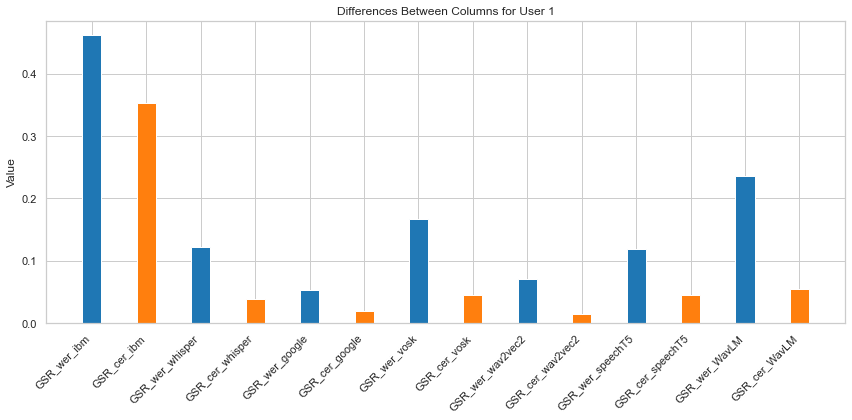

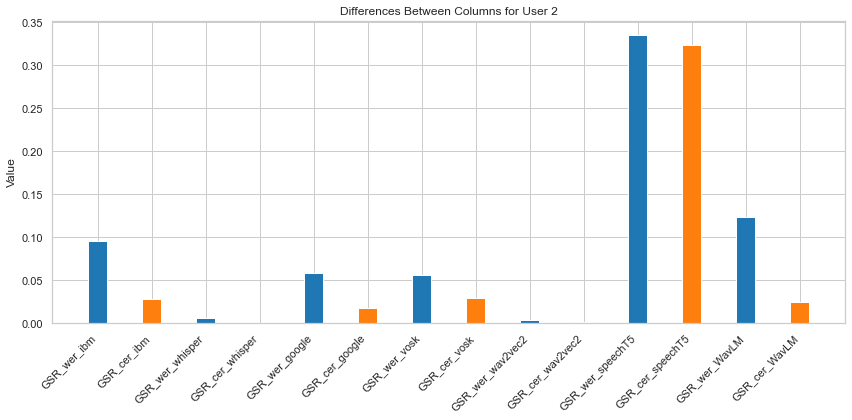

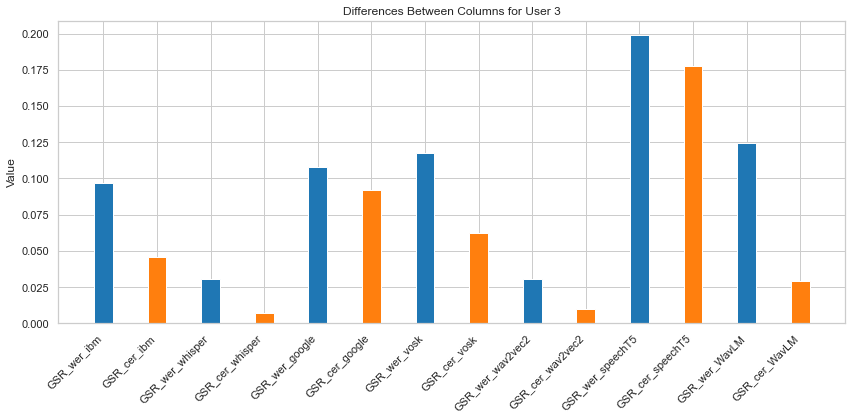

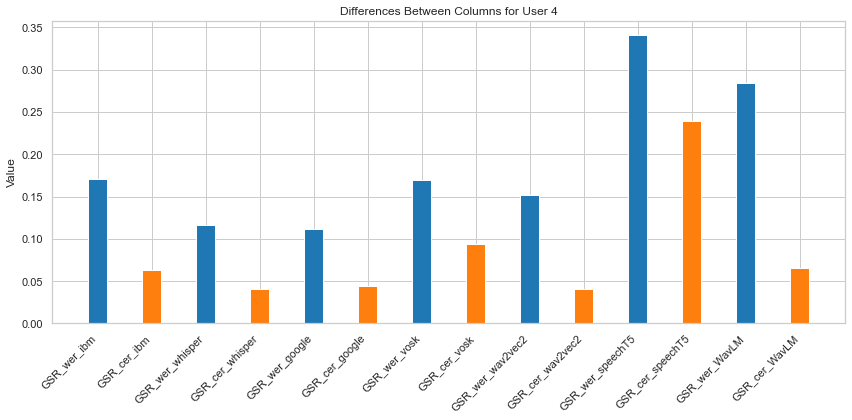

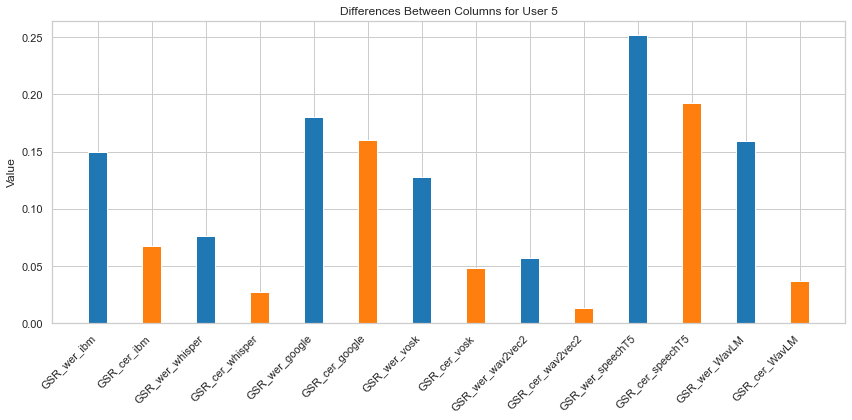

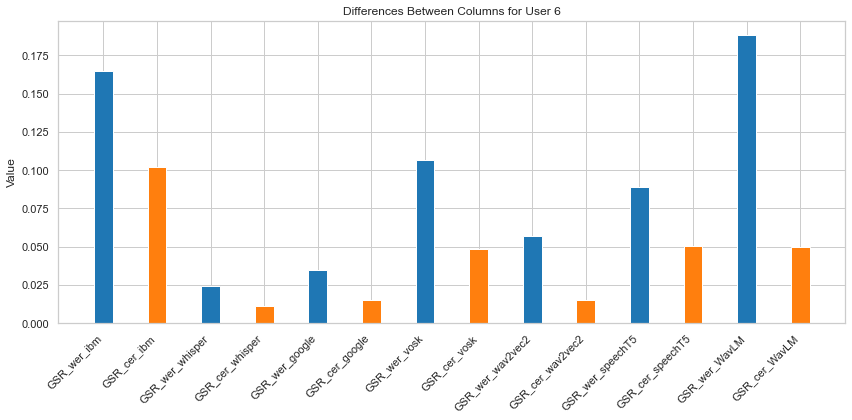

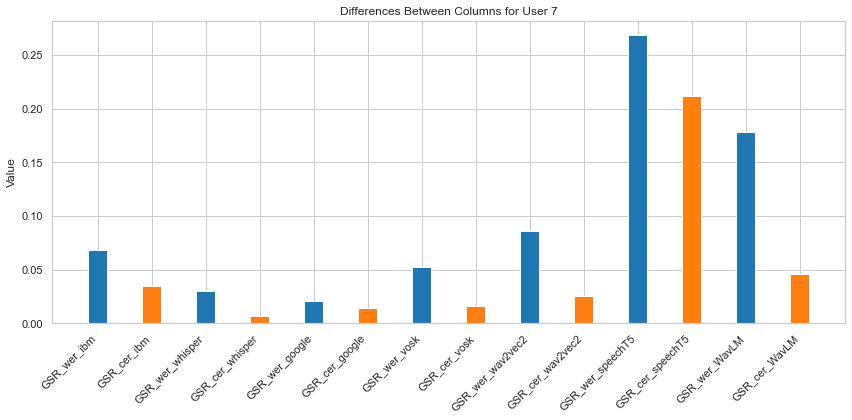

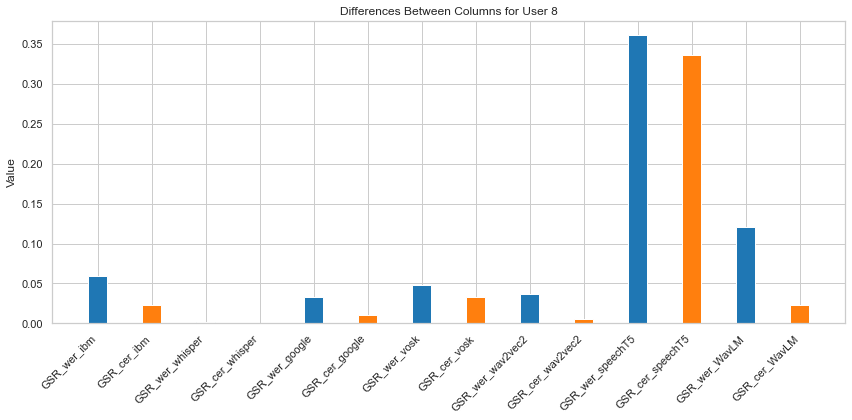

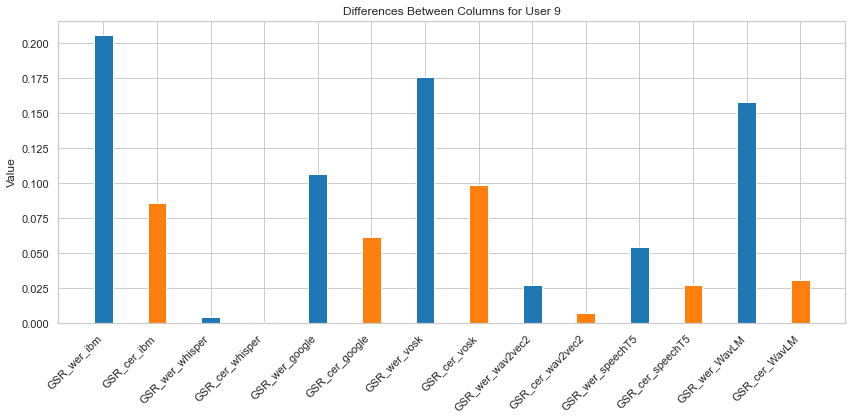

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Get the row index
row_index = combined_stats_full.index

# Get the column names
column_names = combined_stats_full.columns

# Set the width of each bar
bar_width = 0.35

# Define the colors for WER and CER bars
wer_color = '#1f77b4'  # Blue
cer_color = '#ff7f0e'  # Orange

# Loop through each row in the dataframe
for i in row_index:
    # Create a new figure and axes for each row
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get the values for the row
    values = combined_stats_full.iloc[i].values

    # Calculate the x positions for the bars
    x = np.arange(len(values))

    # Plot the bars for WER
    ax.bar(x, values, bar_width, color=[wer_color if 'wer' in col else cer_color for col in column_names])

    # Set the x-axis tick positions and labels
    ax.set_xticks(np.arange(len(column_names)))
    ax.set_xticklabels(column_names, rotation=45, ha='right')

    # Set the y-axis label
    ax.set_ylabel('Value')

    # Set the title
    ax.set_title(f'Differences Between Columns for User {i+1}')

    # Show the plot
    plt.tight_layout()
    plt.show()


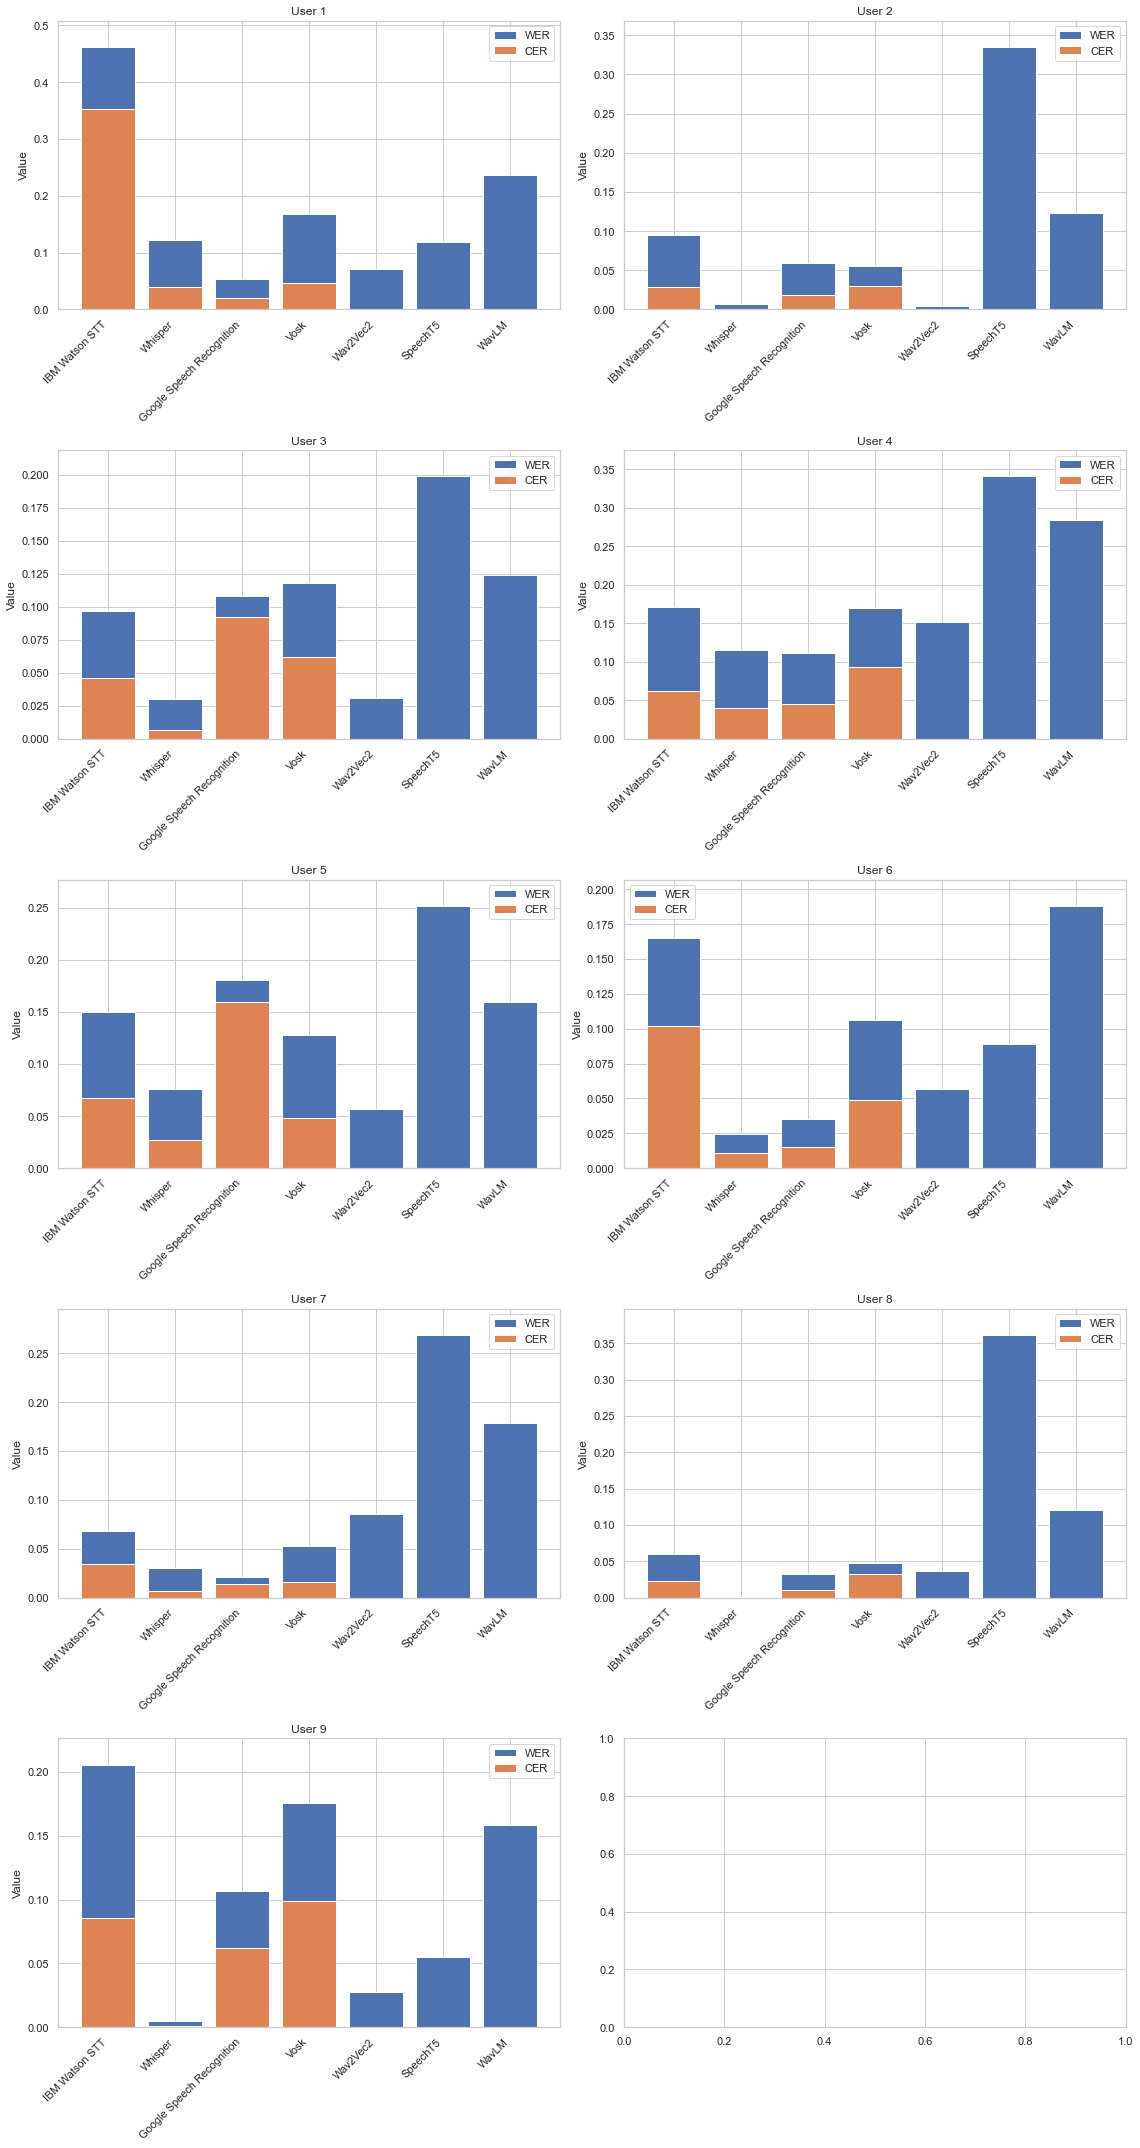

In [138]:
import matplotlib.pyplot as plt

# Get the number of users (number of rows in the dataframe)
num_users = len(combined_stats_full)

# Define the subplot grid dimensions based on the number of users
num_cols = 2  # Number of columns in the grid
num_rows = (num_users + num_cols - 1) // num_cols  # Number of rows in the grid

# Set the figure size based on the number of users
fig_width = 16
fig_height = num_rows * 6  # Adjust the height as per your preference
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axs array to handle both single and multiple subplots
axs = axs.flatten()

# Loop through each user and create a subplot
for i, ax in enumerate(axs):
    # Check if the current user index is valid
    if i < num_users:
        # Get the values for the current user
        wer_values = combined_stats_full.iloc[i][['GSR_wer_ibm', 'GSR_wer_whisper', 'GSR_wer', 'GSR_wer_vosk', 'GSR_wer_wav2vec2', 'GSR_wer_speechT5', 'GSR_wer_WavLM']].values
        cer_values = combined_stats_full.iloc[i][['GSR_cer_ibm', 'GSR_cer_whisper', 'GSR_cer', 'GSR_cer_vosk']].values

        # Plot the bars for WER
        ax.bar(range(len(wer_values)), wer_values, label='WER')

        # Plot the bars for CER
        ax.bar(range(len(cer_values)), cer_values, label='CER')

        # Set the x-axis tick positions and labels
        ax.set_xticks(range(len(wer_values)))
        ax.set_xticklabels(['IBM Watson STT', 'Whisper', 'Google Speech Recognition', 'Vosk', 'Wav2Vec2', 'SpeechT5', 'WavLM'], rotation=45, ha='right')

        # Set the y-axis label
        ax.set_ylabel('Value')

        # Set the title
        ax.set_title(f'User {i+1}')

        # Add a legend
        ax.legend()

        # Set the y-axis limits based on the maximum value
        max_value = max(max(wer_values), max(cer_values))
        ax.set_ylim(0, max_value * 1.1)  # Adjust the factor as per your preference to leave some space at the top

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [104]:
#df_selected.to_csv('df_selected.csv', index=False)

In [105]:
#combined_stats_full.to_csv('combined_stats.csv', index=False)

In [1]:
import pandas as pd

In [4]:
combined_stats_full = pd.read_csv("combined_stats.csv")

In [5]:
combined_stats_full.head()

,GSR_wer_ibm,GSR_cer_ibm,GSR_wer_whisper,GSR_cer_whisper,GSR_wer,GSR_cer,GSR_wer_vosk,GSR_cer_vosk,GSR_wer_wav2vec2,GSR_cer_wav2vec2,GSR_wer_speechT5,GSR_cer_speechT5,GSR_wer_WavLM,GSR_cer_WavLM
0,0.461722,0.352569,0.122694,0.039336,0.052891,0.020196,0.167230,0.045623,0.070818,0.014578,0.118536,0.044698,0.236750,0.055338
1,0.095289,0.028151,0.006517,0.000904,0.058803,0.018062,0.055954,0.029463,0.004040,0.001150,0.334984,0.323414,0.123062,0.024900
2,0.096681,0.045802,0.030543,0.006901,0.108105,0.092024,0.117906,0.062007,0.030684,0.009734,0.198932,0.177442,0.124542,0.029528
3,0.170637,0.062522,0.115846,0.040396,0.111198,0.044696,0.169941,0.093464,0.151744,0.040590,0.340953,0.239116,0.284526,0.066026
4,0.150037,0.067237,0.076022,0.026926,0.180195,0.159878,0.127820,0.048552,0.056951,0.013355,0.251760,0.192581,0.159437,0.037228


In [6]:
df_selected = pd.read_csv("df_selected.csv")

In [7]:
df_selected.head()

,audio,original_text,user,audio_length,google_speech_recognition,latency,GSR_wer,GSR_cer,whisper_transcription,latency_whisper,...,speechT5,latency_speechT5,GSR_wer_speechT5,GSR_cer_speechT5,WavLM,latency_WavLM,GSR_wer_WavLM,GSR_cer_WavLM,GSR_wer_whisper,GSR_cer_whisper
0,121-121726-0009,hotel a place where a guest often gives up goo...,1,7.260000,hotel a place where a guest often gives up goo...,3.735880,0.000000,0.000000,hotel a place where a guest often gives up goo...,4.417003,...,how tell a place where a guest often gives up ...,7.149077,0.142857,0.041096,hotel a place where a guest often gives up god...,4.141935,0.214286,0.041096,0.000000,0.000000
1,121-121726-0011,husband the next thing to a wife,1,4.035011,husband the next thing to a wife,1.719254,0.000000,0.000000,husband the next thing to a wife,2.455993,...,husband the next thing to a wife,3.368605,0.000000,0.000000,husband the next thing to a wife,1.967100,0.000000,0.000000,0.000000,0.000000
2,121-121726-0000,also a popular contrivance whereby love making...,1,8.460000,also a popular contrivance where am i love mak...,5.110257,0.176471,0.048077,also a popular contrivance whereby lovemaking ...,4.317165,...,also a popular contrivance whereby love making...,8.696268,0.058824,0.067308,also a popular condrivance where by love makin...,3.853886,0.235294,0.028846,0.117647,0.009615
3,121-121726-0013,tied to a woman,1,2.490023,tied to a woman,6.851498,0.000000,0.000000,tied to a woman,7.189541,...,tied to a woman,1.915039,0.000000,0.000000,tid to a woman,1.088877,0.250000,0.066667,0.000000,0.000000
4,121-121726-0005,hedge a fence,1,3.100000,hedge a fence,1.624808,0.000000,0.000000,hedge offense,2.156522,...,hedge offense,2.159248,0.666667,0.230769,hedge ofence,1.343533,0.666667,0.153846,0.666667,0.230769


In [8]:
df_selected.columns

Index(['audio', 'original_text', 'user', 'audio_length',
       'google_speech_recognition', 'latency', 'GSR_wer', 'GSR_cer',
       'whisper_transcription', 'latency_whisper', 'ibm_watson_stt',
       'latency_ibm', 'GSR_wer_ibm', 'GSR_cer_ibm', 'vosk_stt', 'latency_vosk',
       'GSR_wer_vosk', 'GSR_cer_vosk', 'wav2vec2', 'latency_wav2vec2',
       'GSR_wer_wav2vec2', 'GSR_cer_wav2vec2', 'speechT5', 'latency_speechT5',
       'GSR_wer_speechT5', 'GSR_cer_speechT5', 'WavLM', 'latency_WavLM',
       'GSR_wer_WavLM', 'GSR_cer_WavLM', 'GSR_wer_whisper', 'GSR_cer_whisper'],
      dtype='object')

In [13]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_gsr_df = df_selected.groupby('audio_length_category')['latency'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_gsr_df)

     audio_length_category    latency
0              0-5 seconds   3.178067
1             5-10 seconds   4.879102
2            10-15 seconds   7.729356
3            15-20 seconds   9.542214
4  greater than 20 seconds  15.574156


In [14]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_whisper_df = df_selected.groupby('audio_length_category')['latency_whisper'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_whisper_df)

     audio_length_category  latency_whisper
0              0-5 seconds         4.176082
1             5-10 seconds         5.829486
2            10-15 seconds         6.190189
3            15-20 seconds         7.742852
4  greater than 20 seconds        14.970668


In [17]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_ibm_df = df_selected.groupby('audio_length_category')['latency_ibm'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_ibm_df)

     audio_length_category  latency_ibm
0              0-5 seconds     3.303906
1             5-10 seconds     5.316966
2            10-15 seconds     6.951130
3            15-20 seconds     8.799383
4  greater than 20 seconds    11.997717


In [18]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_vosk_df = df_selected.groupby('audio_length_category')['latency_vosk'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_vosk_df)

     audio_length_category  latency_vosk
0              0-5 seconds      2.099033
1             5-10 seconds      4.469292
2            10-15 seconds      6.210123
3            15-20 seconds      6.713359
4  greater than 20 seconds     13.078123


In [19]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_wav2vec2_df = df_selected.groupby('audio_length_category')['latency_wav2vec2'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_wav2vec2_df)

     audio_length_category  latency_wav2vec2
0              0-5 seconds          1.890461
1             5-10 seconds          3.803711
2            10-15 seconds          6.878650
3            15-20 seconds          9.776044
4  greater than 20 seconds         18.280879


In [20]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_speechT5_df = df_selected.groupby('audio_length_category')['latency_speechT5'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_speechT5_df)

     audio_length_category  latency_speechT5
0              0-5 seconds          3.950593
1             5-10 seconds          7.929646
2            10-15 seconds         11.825930
3            15-20 seconds         15.126746
4  greater than 20 seconds         25.480581


In [21]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_speechT5_df = df_selected.groupby('audio_length_category')['latency_speechT5'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_speechT5_df)

     audio_length_category  latency_speechT5
0              0-5 seconds          3.950593
1             5-10 seconds          7.929646
2            10-15 seconds         11.825930
3            15-20 seconds         15.126746
4  greater than 20 seconds         25.480581


In [22]:
# Define the bins for audio lengths
bins = [0, 5, 10, 15 , 20 , float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds','10-15 seconds','15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Calculate the average latency for each audio length category
average_latency_wavLM_df = df_selected.groupby('audio_length_category')['latency_WavLM'].mean().reset_index()

# Now, average_latency_df contains the average latency for each audio length category
print(average_latency_wavLM_df)

     audio_length_category  latency_WavLM
0              0-5 seconds       1.737623
1             5-10 seconds       3.481335
2            10-15 seconds       6.779305
3            15-20 seconds       8.948712
4  greater than 20 seconds      17.208788


In [24]:
import pandas as pd

# Assuming your DataFrame is named 'df_selected'
# Define the bins for audio lengths
bins = [0, 5, 10, 15, 20, float('inf')]

# Define the labels for each bin/category
labels = ['0-5 seconds', '5-10 seconds', '10-15 seconds', '15-20 seconds', 'greater than 20 seconds']

# Use the pandas cut function to categorize 'audio_length' into the specified bins
df_selected['audio_length_category'] = pd.cut(df_selected['audio_length'], bins=bins, labels=labels)

# Get a list of columns that contain latency information (excluding 'audio_length' and 'audio_length_category')
latency_columns = [col for col in df_selected.columns if col.startswith('latency')]

# Create an empty DataFrame to store the average latency for each model and category
average_latency_df = pd.DataFrame()

# Loop through each latency column and calculate the average latency for each audio length category
for col in latency_columns:
    model = col.replace('latency_', '')
    avg_latency_df = df_selected.groupby(['audio_length_category'])[col].mean().reset_index()
    avg_latency_df.rename(columns={col: f'average_latency_{model}'}, inplace=True)
    
    if average_latency_df.empty:
        average_latency_df = avg_latency_df
    else:
        average_latency_df = pd.merge(average_latency_df, avg_latency_df, on='audio_length_category')

# Now, average_latency_df contains the average latency for each audio length category for all models
print(average_latency_df)


     audio_length_category  average_latency_latency  average_latency_whisper  \
0              0-5 seconds                 3.178067                 4.176082   
1             5-10 seconds                 4.879102                 5.829486   
2            10-15 seconds                 7.729356                 6.190189   
3            15-20 seconds                 9.542214                 7.742852   
4  greater than 20 seconds                15.574156                14.970668   

   average_latency_ibm  average_latency_vosk  average_latency_wav2vec2  \
0             3.303906              2.099033                  1.890461   
1             5.316966              4.469292                  3.803711   
2             6.951130              6.210123                  6.878650   
3             8.799383              6.713359                  9.776044   
4            11.997717             13.078123                 18.280879   

   average_latency_speechT5  average_latency_WavLM  
0                  3.

In [25]:
import pandas as pd
from IPython.display import display, HTML

# Assuming you have the DataFrame 'average_latency_df' containing the average latency values for each audio length category and model

# Create a copy of the DataFrame and apply styling
styled_average_latency = average_latency_df.style \
    .set_table_styles([
        {'selector': 'table',
         'props': [('border-collapse', 'collapse'), ('border-spacing', '0'), ('width', '100%'), ('font-family', 'Arial, sans-serif')]},
        {'selector': 'th',
         'props': [('background-color', '#F5F5F5'), ('border', '1px solid #CCCCCC'), ('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td',
         'props': [('border', '1px solid #CCCCCC'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)',
         'props': [('background-color', '#F9F9F9')]},
        {'selector': 'tr:hover',
         'props': [('background-color', '#F1F1F1')]},
        {'selector': 'caption',
         'props': [('text-align', 'left'), ('font-size', '14px'), ('font-weight', 'bold'), ('margin-bottom', '10px')]}
    ]) \
    .bar(subset=average_latency_df.columns[1:], color=['#FACD00', '#F9E5CF']) \
    .highlight_min(subset=average_latency_df.columns[1:], color='#FFEDBF')

# Set the caption for the DataFrame
styled_average_latency.set_caption('Average Latency Statistics')

# Display the styled DataFrame
display(HTML(styled_average_latency.render()))


,audio_length_category,average_latency_latency,average_latency_whisper,average_latency_ibm,average_latency_vosk,average_latency_wav2vec2,average_latency_speechT5,average_latency_WavLM
0,0-5 seconds,3.178067,4.176082,3.303906,2.099033,1.890461,3.950593,1.737623
1,5-10 seconds,4.879102,5.829486,5.316966,4.469292,3.803711,7.929646,3.481335
2,10-15 seconds,7.729356,6.190189,6.951130,6.210123,6.878650,11.825930,6.779305
3,15-20 seconds,9.542214,7.742852,8.799383,6.713359,9.776044,15.126746,8.948712
4,greater than 20 seconds,15.574156,14.970668,11.997717,13.078123,18.280879,25.480581,17.208788


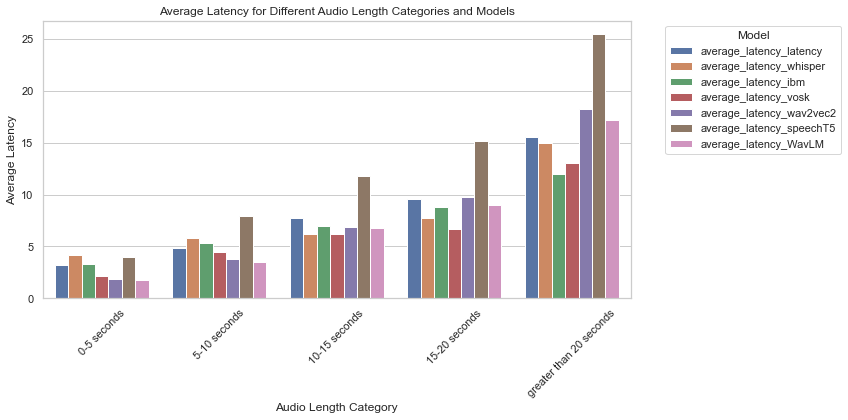

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'average_latency_df' containing the average latency values for each audio length category and model

# Set the style for the plots (optional, but can make the plots look better)
sns.set(style="whitegrid")

# Melt the DataFrame to have a 'model' column with the names of each model
melted_df = average_latency_df.melt(id_vars='audio_length_category', var_name='model', value_name='average_latency')

# Plot the average latency for each audio length category and model using a bar plot
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
sns.barplot(x='audio_length_category', y='average_latency', hue='model', data=melted_df)

# Set plot labels and title
plt.xlabel('Audio Length Category')
plt.ylabel('Average Latency')
plt.title('Average Latency for Different Audio Length Categories and Models')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
